A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia. The data is provided in the CSV file below.

 

The company is looking at prospective properties to buy to enter the market. You are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.

 

The company wants to know:

1. Which variables are significant in predicting the price of a house, and

2. How well those variables describe the price of a house.

Also, determine the optimal value of lambda for ridge and lasso regression.

### Business Goal 

You are required to model the price of houses with the available independent variables. This model will then be used by the management to understand how exactly the prices vary with the variables. They can accordingly manipulate the strategy of the firm and concentrate on areas that will yield high returns. Further, the model will be a good way for management to understand the pricing dynamics of a new market.

In [153]:
import warnings
warnings.filterwarnings('ignore')

In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
pd.set_option('display.max_columns', None) 
pd.set_option("display.max_rows", 100)

### Reading the data

In [155]:
house_df = pd.read_csv('train.csv')
house_df_copy = house_df.copy()
house_df.head()
house_df.BedroomAbvGr.unique()

array([3, 4, 1, 2, 0, 5, 6, 8])

### Visualising and cleaning data

#### Checking the numerical value relationships

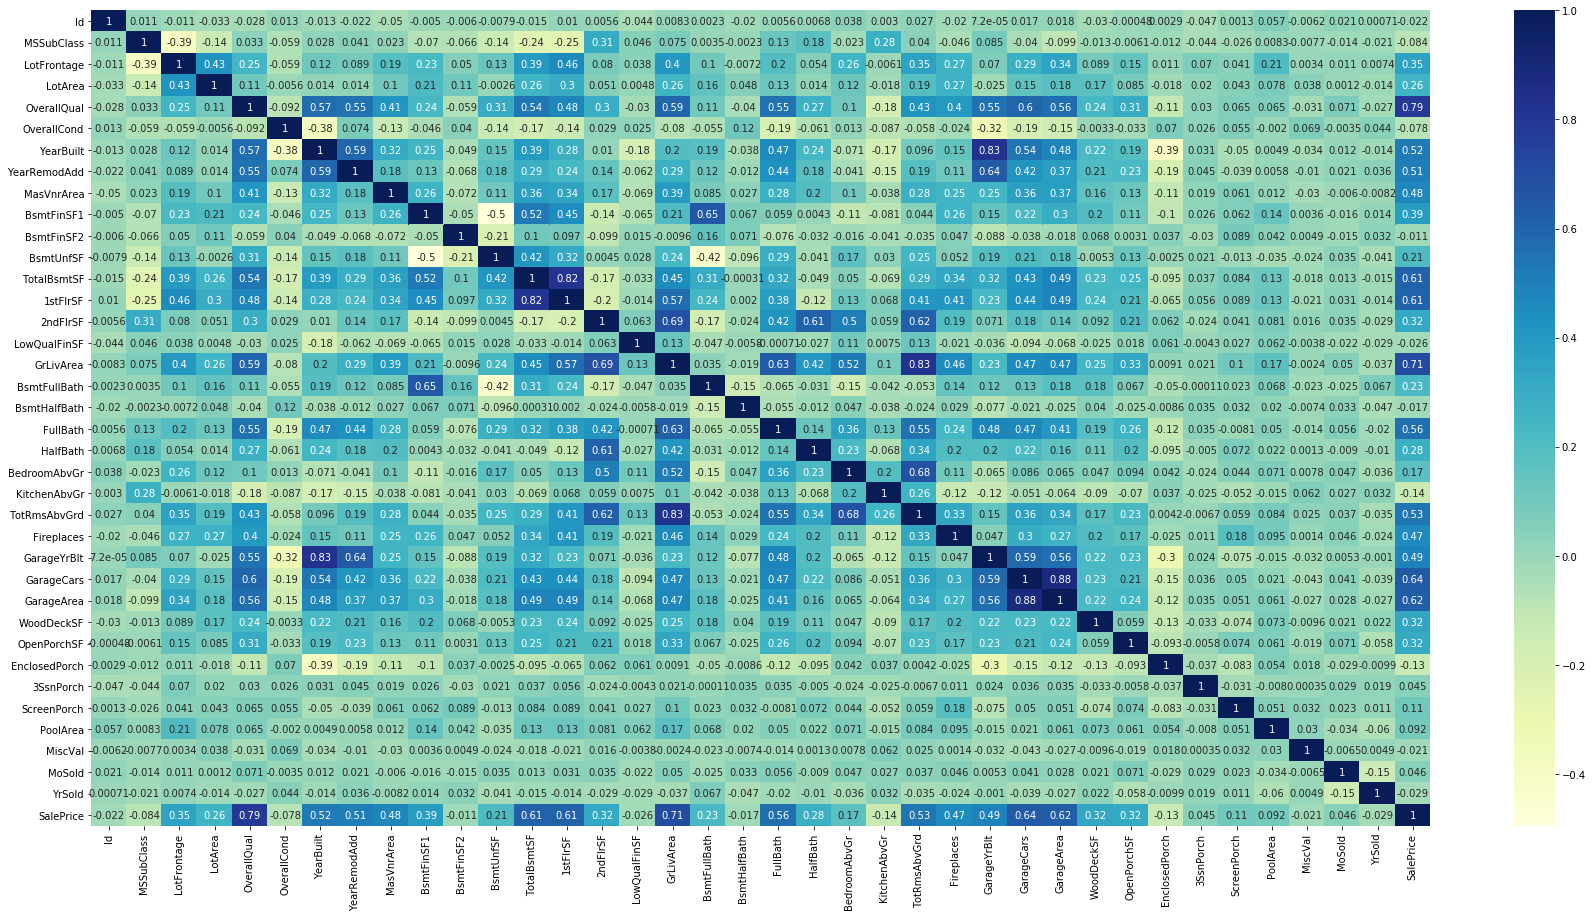

In [156]:
plt.figure(figsize=(30, 15))
sns.heatmap(
    house_df.corr(), annot=True, cmap="YlGnBu",
)

#### Checking data types

In [157]:
house_df.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating           object


#### Checking for duplicate rows

In [158]:
house_df[house_df.duplicated()]

Empty DataFrame
Columns: [Id, MSSubClass, MSZoning, LotFrontage, LotArea, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, PoolQC, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition, SalePrice]
Index: []

#### Remove columns having single unique value as they will not give value for our analysis


In [159]:
house_df = house_df[
    [column for column in list(house_df) if house_df[column].nunique() > 1]
]
len(house_df.columns)

81

#### Checking null percent of columns

In [160]:
house_df.isnull().sum() / len(house_df) *100

Id                0.000000
MSSubClass        0.000000
MSZoning          0.000000
LotFrontage      17.739726
LotArea           0.000000
Street            0.000000
Alley            93.767123
LotShape          0.000000
LandContour       0.000000
Utilities         0.000000
LotConfig         0.000000
LandSlope         0.000000
Neighborhood      0.000000
Condition1        0.000000
Condition2        0.000000
BldgType          0.000000
HouseStyle        0.000000
OverallQual       0.000000
OverallCond       0.000000
YearBuilt         0.000000
YearRemodAdd      0.000000
RoofStyle         0.000000
RoofMatl          0.000000
Exterior1st       0.000000
Exterior2nd       0.000000
MasVnrType        0.547945
MasVnrArea        0.547945
ExterQual         0.000000
ExterCond         0.000000
Foundation        0.000000
BsmtQual          2.534247
BsmtCond          2.534247
BsmtExposure      2.602740
BsmtFinType1      2.534247
BsmtFinSF1        0.000000
BsmtFinType2      2.602740
BsmtFinSF2        0.000000
B

#### Replacing nulls with default values

In [161]:
house_df.Fence.fillna('NA', inplace=True)
house_df.FireplaceQu.fillna('NA', inplace=True)
house_df.LotFrontage.fillna(house_df.LotFrontage.median(), inplace=True)

In [162]:
# List of Columns & NA counts where NA values are more than 30%
NA_columns = house_df.isnull().sum()
NA_columns = NA_columns[NA_columns.values >= (0.3 * len(house_df))].index
house_df.drop(labels=NA_columns, axis=1, inplace=True)
# Removing id column as it is not important
house_df.drop('Id', inplace=True, axis=1)
house_df.drop('MoSold', inplace=True, axis=1)
house_df.shape


(1460, 76)

#### Removing rows with null values

In [163]:

house_df.dropna(inplace=True)
house_df.shape

(1338, 76)

#### Converting year to age

In [164]:
house_df['Age'] = 2020 - house_df.YearBuilt
house_df['RemodAge'] = 2020 - house_df.YearRemodAdd
house_df['SoldAge'] = 2020 - house_df.YrSold
house_df.drop(['YearBuilt', 'YearRemodAdd', 'YrSold'], axis=1, inplace=True)

#### Removing outliers

In [165]:
house_df = house_df[(house_df["LotArea"] < house_df["LotArea"].quantile(0.95))]
house_df = house_df[(house_df["LotFrontage"] < house_df["LotFrontage"].quantile(0.996))]
house_df = house_df[(house_df["MasVnrArea"] < house_df["MasVnrArea"].quantile(0.95))]
house_df = house_df[(house_df["BsmtFinSF1"] < house_df["BsmtFinSF1"].quantile(0.98))]
house_df = house_df[(house_df["2ndFlrSF"] < house_df["2ndFlrSF"].quantile(0.99))]
house_df = house_df[(house_df["SalePrice"] < house_df["SalePrice"].quantile(0.99))]

In [166]:
house_df.describe()

MSSubClass  LotFrontage       LotArea  OverallQual  OverallCond  \
count  1151.000000  1151.000000   1151.000000  1151.000000  1151.000000   
mean     56.533449    67.939183   9125.746308     6.057341     5.626412   
std      41.686391    17.510338   3065.227749     1.208742     1.077581   
min      20.000000    21.000000   1300.000000     2.000000     2.000000   
25%      20.000000    60.000000   7417.500000     5.000000     5.000000   
50%      50.000000    69.000000   9179.000000     6.000000     5.000000   
75%      70.000000    78.000000  10996.000000     7.000000     6.000000   
max     190.000000   130.000000  17503.000000    10.000000     9.000000   

        MasVnrArea   BsmtFinSF1   BsmtFinSF2    BsmtUnfSF  TotalBsmtSF  \
count  1151.000000  1151.000000  1151.000000  1151.000000  1151.000000   
mean     72.793223   411.982624    46.890530   576.168549  1035.041703   
std     112.545553   377.588612   159.670204   420.777542   326.543324   
min       0.000000     0.000000     0.000000     0.000000   105.000000   
25%       0.000000     0.000000     0.000000   254.000000   806.000000   
50%       0.000000   387.000000     0.000000   490.000000   978.000000   
75%     130.000000   685.000000     0.000000   809.000000  1232.000000   
max     448.000000  1373.000000  1474.000000  2042.000000  2524.000000   

          1stFlrSF     2ndFlrSF  LowQualFinSF    GrLivArea  BsmtFullBath  \
count  1151.000000  1151.000000   1151.000000  1151.000000   1151.000000   
mean   1116.675065   330.078193      4.070374  1450.823632      0.409209   
std     326.077268   406.240639     38.898589   428.760419      0.498923   
min     438.000000     0.000000      0.000000   438.000000      0.000000   
25%     874.000000     0.000000      0.000000  1122.500000      0.000000   
50%    1060.000000     0.000000      0.000000  1416.000000      0.000000   
75%    1317.500000   718.000000      0.000000  1710.000000      1.000000   
max    2898.000000  1323.000000    528.000000  3194.000000      2.000000   

       BsmtHalfBath     FullBath     HalfBath  BedroomAbvGr  KitchenAbvGr  \
count   1151.000000  1151.000000  1151.000000   1151.000000   1151.000000   
mean       0.059948     1.523892     0.378801      2.841877      1.030408   
std        0.241127     0.526756     0.499428      0.750201      0.176772   
min        0.000000     0.000000     0.000000      0.000000      1.000000   
25%        0.000000     1.000000     0.000000      2.000000      1.000000   
50%        0.000000     2.000000     0.000000      3.000000      1.000000   
75%        0.000000     2.000000     1.000000      3.000000      1.000000   
max        2.000000     3.000000     2.000000      6.000000      3.000000   

       TotRmsAbvGrd   Fireplaces  GarageYrBlt   GarageCars   GarageArea  \
count   1151.000000  1151.000000  1151.000000  1151.000000  1151.000000   
mean       6.368375     0.573414  1977.299739     1.790617   475.900087   
std        1.437331     0.618235    25.018421     0.606156   169.955824   
min        3.000000     0.000000  1900.000000     1.000000   160.000000   
25%        5.000000     0.000000  1960.000000     1.000000   340.000000   
50%        6.000000     1.000000  1978.000000     2.000000   472.000000   
75%        7.000000     1.000000  2001.000000     2.000000   572.500000   
max       12.000000     3.000000  2010.000000     4.000000  1390.000000   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  1151.000000  1151.000000    1151.000000  1151.000000  1151.000000   
mean     88.551694    43.716768      21.982624     3.102520    14.251955   
std     116.718691    61.358686      59.831805    28.731741    52.383825   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    24.000000       0.000000     0.000000     0.000000   
75%     164.000000    64.000000       0.000000     0.000000     0.000000   
ma

#### Creating dummy variables

In [167]:
def create_dummy_variable(df, column):
    dummy_df = pd.get_dummies(df[column], drop_first=True)
    dummy_column_names = []
    for category in dummy_df.columns:
        dummy_column_names.append(str(column)+ '_'+str(category))
    dummy_df.columns = dummy_column_names
    df = pd.concat([df, dummy_df], axis=1)
    df = df.drop(column, axis=1)
    return df, dummy_df

In [168]:
categorical_variables = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

In [169]:
# Removing column names from categorical variables which have been already removed from 
categorical_variables_temp = categorical_variables.copy()
for column in categorical_variables_temp:
    if column not in house_df.columns:
        categorical_variables.remove(column)
        print('removed: ' + column)

removed: Alley
removed: PoolQC
removed: MiscFeature


#### Creating dummy variables from categorical variables

In [170]:
for column in categorical_variables:
    house_df, df_dummy = create_dummy_variable(house_df, column)

### Model Building

#### Creating test train data

In [410]:
y = house_df.loc[:, 'SalePrice']
X = house_df.loc[:, house_df.columns != 'SalePrice']

# scale
scaler = StandardScaler()
scaler.fit(X)

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 1)

In [411]:
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 100)

rfe = rfe.fit(X_train, y_train)

In [412]:
# Columns filtered by RFE
cols = X_train.columns[rfe.support_]

#### Training model using Lasso

In [413]:
# grid search CV

# set up cross validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)

# specify range of hyperparameters
params = {'alpha': [0.001, 0.01, 1.0, 5.0, 10.0, 100.0, 500.0, 1000.0]}

# grid search
# lasso model
model = Lasso()
model_cv = GridSearchCV(estimator = model, param_grid = params, 
                        scoring= 'r2', 
                        cv = folds, 
                        return_train_score=True, verbose = 1)            
model_cv.fit(X_train[cols], y_train) 

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.7s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.001, 0.01, 1.0, 5.0, 10.0, 100.0, 500.0,
                                   1000.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='r2', verbose=1)

In [414]:
print(model_cv.best_params_)
print(model_cv.best_score_)

{'alpha': 10.0}
0.8227882560550361


In [415]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.T

0                1               2  \
mean_fit_time              0.0319149        0.0347038       0.0184658   
std_fit_time              0.00224243       0.00126568      0.00562571   
mean_score_time          0.000914574       0.00104108     0.000944471   
std_score_time           7.53543e-05      0.000146615     0.000139709   
param_alpha                    0.001             0.01               1   
params              {'alpha': 0.001}  {'alpha': 0.01}  {'alpha': 1.0}   
split0_test_score           0.824757         0.824757        0.824869   
split1_test_score             0.7791         0.779116         0.78052   
split2_test_score            0.85658         0.856587        0.857317   
split3_test_score           0.829558         0.829614        0.831099   
split4_test_score           0.795508         0.795516         0.79626   
mean_test_score             0.817101         0.817118        0.818013   
std_test_score             0.0271393        0.0271408       0.0269888   
rank_test_score                    6                5               4   
split0_train_score          0.876793         0.876793        0.876779   
split1_train_score          0.883138         0.883138         0.88312   
split2_train_score          0.872557         0.872557        0.872539   
split3_train_score          0.876185         0.876185        0.876166   
split4_train_score           0.88399          0.88399        0.883975   
mean_train_score            0.878533         0.878533        0.878516   
std_train_score           0.00436428       0.00436428      0.00436498   

                                 3                4                 5  \
mean_fit_time            0.0138213        0.0105671        0.00366249   
std_fit_time             0.0032936       0.00112696       0.000297269   
mean_score_time        0.000821543       0.00099659       0.000782347   
std_score_time         3.14465e-05      0.000103323       4.81616e-05   
param_alpha                      5               10               100   
params              {'alpha': 5.0}  {'alpha': 10.0}  {'alpha': 100.0}   
split0_test_score         0.825642         0.825962          0.832861   
split1_test_score         0.785739         0.790102          0.796692   
split2_test_score         0.859879          0.86147          0.851098   
split3_test_score         0.835239         0.837458           0.83708   
split4_test_score          0.79819         0.798949           0.78745   
mean_test_score           0.820938         0.822788          0.821036   
std_test_score           0.0264558        0.0259163          0.024583   
rank_test_score                  3                1                 2   
split0_train_score        0.876482          0.87572          0.854118   
split1_train_score        0.882718         0.881676          0.863197   
split2_train_score        0.872116         0.871026          0.846646   
split3_train_score        0.875738         0.874692          0.852121   
split4_train_score        0.883642         0.882801          0.858768   
mean_train_score          0.878139         0.877183           0.85497   
std_train_score         0.00438289       0.00442733        0.00566118   

                                   6                  7  
mean_fit_time             0.00242124         0.00212173  
std_fit_time             7.67726e-05        2.94187e-05  
mean_score_time          0.000784731        0.000762033  
std_score_time            4.1853e-05        3.04614e-05  
param_alpha                      500               1000  
params              {'alpha': 500.0}  {'alpha': 1000.0}  
split0_test_score           0.777492           0.756443  
split1_test_score           0.760613           0.745546  
split2_test_score           0.794739           0.781273  
split3_test_score           0.791651           0.778054  
split4_test_score           0.747522           0.733159  
mean_test_score             0.774403           0.758895  
std_test_score             0.0180739          0.0185172  
rank_test

##### Both in test and train score, variation seems to be least when alpha's value is 10

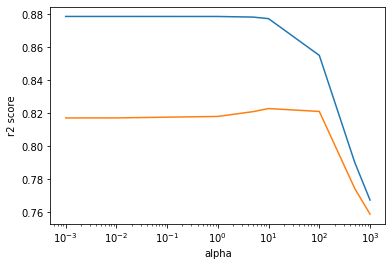

In [416]:
# plot
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('r2 score')
plt.xscale('log')
plt.show()

In [417]:
# model with optimal alpha
# lasso regression
lm = Lasso(alpha=10)
lm.fit(X_train[cols], y_train)

# predict
y_train_pred = lm.predict(X_train[cols])
print(r2_score(y_true=y_train, y_pred=y_train_pred))
y_test_pred = lm.predict(X_test[cols])
print(r2_score(y_true=y_test, y_pred=y_test_pred))

0.8728823889088394
0.8160042394378458


In [418]:
# lasso model parameters
model_parameters = list(lm.coef_)
model_parameters.insert(0, lm.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = X.columns
cols = cols.insert(0, "constant")
parameters_list = list(zip(cols, model_parameters))

In [419]:
parameters_list = [parameter for parameter in parameters_list if parameter[1] != 0]

In [420]:
parameter_df = pd.DataFrame(parameters_list, columns=['variable', 'factor'])
parameter_df = parameter_df.sort_values(by='factor', ascending=False).set_index('variable')
parameter_df = parameter_df[parameter_df.index != 'constant']
parameter_df

factor
variable                       
RemodAge              98600.081
MSSubClass_190        58076.916
PoolArea              46891.181
2ndFlrSF              41907.485
OpenPorchSF           31735.678
Age                   27740.278
MSSubClass_160        27212.301
3SsnPorch             25873.333
LowQualFinSF          25863.860
MSSubClass_75         25615.696
GrLivArea             24308.256
Fireplaces            23669.148
MiscVal               22624.062
EnclosedPorch         21822.014
Neighborhood_Blueste  19112.144
GarageYrBlt           18976.416
Condition2_Feedr      18129.509
MSSubClass_180        18087.941
WoodDeckSF            15985.703
MasVnrArea            15235.966
TotRmsAbvGrd          15024.800
LandContour_Lvl       14501.612
Neighborhood_Sawyer   13946.869
BsmtFullBath          13495.402
LotShape_Reg          12953.584
Neighborhood_NridgHt  12686.794
LotFrontage           12506.829
Condition2_PosA       11679.885
Neighborhood_MeadowV  11429.213
Neighborhood_CollgCr  10810.934
Condition1_PosN       10751.023
OverallCond            9645.876
Condition2_Norm        9251.824
LandSlope_Mod          9245.037
Neighborhood_SWISU     9073.516
SoldAge                8534.524
Condition1_RRNn        8117.297
LotShape_IR2           8010.071
Neighborhood_Timber    7909.444
FullBath               7442.340
LandSlope_Sev          7369.856
BsmtFinSF2             7344.667
Neighborhood_BrDale    7084.018
ScreenPorch            6920.371
Neighborhood_OldTown   6472.221
MSSubClass_80          6371.923
LotArea                6052.322
GarageArea             5896.542
Condition1_RRAn        5295.589
Neighborhood_SawyerW   5294.831
MSZoning_RH            4557.966
LotShape_IR3           3751.075
Condition1_RRAe        3326.315
Condition1_Feedr       2246.722
OverallQual            1750.756
MSSubClass_40          -825.240
Neighborhood_Somerst   -857.985
MSSubClass_30          -875.407
Condition1_Norm       -1008.661
Neighborhood_Gilbert  -1354.807
Neighborhood_Veenker  -2072.334
HalfBath              -3812.167
BsmtUnfSF             -4177.850
LandContour_HLS       -5689.651
Neighborhood_ClearCr  -6244.863
BedroomAbvGr          -6246.679
MSZoning_RM           -6683.808
Neighborhood_Edwards  -7224.715
1stFlrSF              -7407.775
LandContour_Low       -7668.784
GarageCars            -8295.292
Neighborhood_IDOTRR   -8708.355
MSSubClass_70         -8746.628
Neighborhood_Mitchel  -8929.578
KitchenAbvGr          -9558.569
Neighborhood_Crawfor -10537.698
MSZoning_FV          -12188.522
LotConfig_FR3        -14137.099
TotalBsmtSF          -14175.308
Neighborhood_BrkSide -14567.903
MSSubClass_90        -16874.305
LotConfig_CulDSac    -19663.298
LotConfig_Inside     -21165.335
MSZoning_RL          -21912.514
MSSubClass_60        -23547.734
LotConfig_FR2        -23974.858
Neighborhood_NPkVill -26975.967
Street_Pave          -27368.225
MSSubClass_50        -29578.967
MSSubClass_85        -31640.396
MSSubClass_45        -32705.095
Neighborhood_NWAmes  -32881.837
Neighborhood_NAmes   -36536.301
Neighborhood_NoRidge -37548.633
MSSubClass_120       -50430.820

### The above vales defines the top predictors that can be used to predict the values of the house. A `positive factor` indicates that the `Sales Price` of house will `rise` factor number of times if the value of variable is increased by one and a `negative factor` indicates that the `Sales Price` will `decrease` factor number of times if variable is increased by one.

`Note`: Variable with underscore means:
name before underscore is property type and name after underscore is property name

#### Creating test train data

In [421]:
y = house_df.loc[:, 'SalePrice']
X = house_df.loc[:, house_df.columns != 'SalePrice']

# scale
scaler = StandardScaler()
scaler.fit(X)

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 1)

In [422]:
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 100)

rfe = rfe.fit(X_train, y_train)

In [423]:
# Columns filtered by RFE
cols = X_train.columns[rfe.support_]

#### Training model using Ridge

In [424]:
# grid search CV

# set up cross validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)

# specify range of hyperparameters
params = {'alpha': [0.001, 0.01, 1.0, 5.0, 10.0, 100.0, 500.0, 1000.0]}

# grid search
# lasso model
model = Ridge()
model_cv = GridSearchCV(estimator = model, param_grid = params, 
                        scoring= 'r2', 
                        cv = folds, 
                        return_train_score=True, verbose = 1)            
model_cv.fit(X_train[cols], y_train) 

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.2s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.001, 0.01, 1.0, 5.0, 10.0, 100.0, 500.0,
                                   1000.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='r2', verbose=1)

In [425]:
print(model_cv.best_params_)
print(model_cv.best_score_)

{'alpha': 1.0}
0.8271156595570854


In [426]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.T

0                1               2  \
mean_fit_time             0.00267391       0.00210423      0.00189619   
std_fit_time             0.000687578      6.75085e-05      2.5282e-05   
mean_score_time          0.000902033      0.000845909      0.00077405   
std_score_time           0.000148643      9.62308e-05     3.03527e-05   
param_alpha                    0.001             0.01               1   
params              {'alpha': 0.001}  {'alpha': 0.01}  {'alpha': 1.0}   
split0_test_score            0.82451         0.824544        0.828215   
split1_test_score           0.779172         0.779814        0.795487   
split2_test_score           0.856615         0.856918        0.860862   
split3_test_score           0.830176         0.831196        0.849244   
split4_test_score           0.795543         0.795849        0.801771   
mean_test_score             0.817203         0.817664        0.827116   
std_test_score              0.027168        0.0271287       0.0255829   
rank_test_score                    5                4               1   
split0_train_score          0.876793         0.876791        0.872359   
split1_train_score          0.883138         0.883135        0.878557   
split2_train_score          0.872557         0.872553        0.866486   
split3_train_score          0.876185          0.87618        0.869655   
split4_train_score           0.88399         0.883987        0.878368   
mean_train_score            0.878533         0.878529        0.873085   
std_train_score           0.00436428       0.00436457      0.00476849   

                                 3                4                 5  \
mean_fit_time            0.0019062       0.00189686        0.00187917   
std_fit_time             2.431e-05      2.65569e-05       1.03446e-05   
mean_score_time        0.000791025      0.000763416       0.000761509   
std_score_time         9.77206e-05      2.38895e-06       7.83523e-07   
param_alpha                      5               10               100   
params              {'alpha': 5.0}  {'alpha': 10.0}  {'alpha': 100.0}   
split0_test_score         0.832289          0.82896          0.782444   
split1_test_score          0.79947         0.797346          0.762672   
split2_test_score         0.854478           0.8476          0.802649   
split3_test_score          0.84889         0.842946          0.793178   
split4_test_score         0.797007         0.790358          0.757374   
mean_test_score           0.826427         0.821442          0.779663   
std_test_score            0.024158        0.0234521         0.0173451   
rank_test_score                  2                3                 6   
split0_train_score        0.858411         0.847296          0.789986   
split1_train_score         0.86577          0.85496          0.796798   
split2_train_score        0.852444         0.842261            0.7879   
split3_train_score        0.854827         0.843736          0.788202   
split4_train_score        0.864586         0.854433          0.799637   
mean_train_score          0.859208         0.848537          0.792505   
std_train_score         0.00524537       0.00529138        0.00480344   

                                   6                  7  
mean_fit_time             0.00188594           0.001896  
std_fit_time             1.13607e-05        2.26378e-05  
mean_score_time          0.000762463        0.000766802  
std_score_time            2.0454e-06        3.17876e-06  
param_alpha                      500               1000  
params              {'alpha': 500.0}  {'alpha': 1000.0}  
split0_test_score           0.699549             0.6235  
split1_test_score           0.694889           0.624605  
split2_test_score            0.73902           0.669171  
split3_test_score           0.718884           0.643867  
split4_test_score           0.703167           0.636587  
mean_test_score             0.711102           0.639546  
std_test_score               0.01612           0.016648  
rank_test

##### Both in test and train score, variation seems to be least when alpha's value is 100

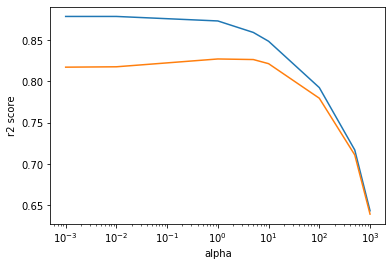

In [427]:
# plot
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('r2 score')
plt.xscale('log')
plt.show()

In [428]:
# model with optimal alpha
# ridge regression
lm = Ridge(alpha=2)
lm.fit(X_train[cols], y_train)

# predict
y_train_pred = lm.predict(X_train[cols])
print(r2_score(y_true=y_train, y_pred=y_train_pred))
y_test_pred = lm.predict(X_test[cols])
print(r2_score(y_true=y_test, y_pred=y_test_pred))

0.8660196432126791
0.8191255473870436


In [429]:
# ridge model parameters
model_parameters = list(lm.coef_)
model_parameters.insert(0, lm.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = X.columns
cols = cols.insert(0, "constant")
parameters_list = list(zip(cols, model_parameters))

In [430]:
parameters_list = [parameter for parameter in parameters_list if parameter[1] != 0]

In [431]:
parameter_df = pd.DataFrame(parameters_list, columns=['variable', 'factor'])
parameter_df = parameter_df.sort_values(by='factor', ascending=False).set_index('variable')
parameter_df = parameter_df[parameter_df.index != 'constant']
parameter_df

factor
variable                       
RemodAge              29644.549
PoolArea              27745.054
OpenPorchSF           27055.064
MSSubClass_190        25595.036
2ndFlrSF              23443.540
MSSubClass_160        21941.917
3SsnPorch             20095.945
EnclosedPorch         19203.132
MiscVal               18146.249
GarageYrBlt           17727.858
Neighborhood_Blueste  17399.270
MSSubClass_180        17107.291
Age                   16022.602
Fireplaces            15728.201
MasVnrArea            15591.102
LotFrontage           14004.303
WoodDeckSF            12825.499
MSSubClass_75         12056.964
MSSubClass_80         11784.676
LotShape_Reg          11691.123
Neighborhood_MeadowV  11516.950
Neighborhood_Sawyer   10076.703
OverallCond            9739.899
Condition2_PosA        9555.848
Neighborhood_CollgCr   9417.641
Neighborhood_Timber    9125.002
Condition2_Feedr       9110.088
Neighborhood_NridgHt   9045.094
GrLivArea              8934.432
LandSlope_Mod          8928.294
Condition2_Norm        8853.957
LandContour_Lvl        8538.368
LowQualFinSF           8250.320
LandSlope_Sev          7591.169
FullBath               7565.738
Neighborhood_BrDale    6665.692
LotShape_IR2           6616.073
LotArea                6364.291
Condition1_RRNn        6243.995
Condition1_RRAn        6241.319
Neighborhood_SWISU     6232.689
Condition1_PosN        6231.421
TotRmsAbvGrd           5777.389
SoldAge                5754.192
ScreenPorch            5551.756
LotShape_IR3           3284.845
Neighborhood_OldTown   3255.185
Condition1_RRAe        2823.644
OverallQual            2800.626
GarageArea             2711.591
BsmtFinSF2             2538.425
Neighborhood_SawyerW   1788.337
Condition1_RRNe        1748.710
BsmtHalfBath            818.786
Condition1_Feedr       -291.850
MSZoning_RH            -769.724
BsmtFullBath          -1340.567
Neighborhood_StoneBr  -1575.326
Condition1_PosA       -2436.922
Condition1_Norm       -2588.431
Neighborhood_Gilbert  -3022.342
BedroomAbvGr          -3077.152
Neighborhood_Veenker  -3228.115
BsmtUnfSF             -3542.556
MSSubClass_40         -3542.556
HalfBath              -3870.417
MSZoning_RM           -4213.807
Neighborhood_Somerst  -4293.284
1stFlrSF              -4923.347
MSSubClass_30         -4923.347
Street_Pave           -5577.957
Neighborhood_ClearCr  -6161.092
BsmtFinSF1            -6322.434
LandContour_HLS       -6611.929
Neighborhood_Edwards  -6762.757
Neighborhood_Mitchel  -6975.027
KitchenAbvGr          -7341.075
Neighborhood_IDOTRR   -7868.263
GarageCars            -8332.350
MSSubClass_70         -8361.336
LandContour_Low       -8512.612
LotConfig_CulDSac     -8755.037
Neighborhood_Crawfor  -8834.226
MSZoning_FV          -10824.188
TotalBsmtSF          -13086.428
Neighborhood_BrkSide -13592.127
LotConfig_FR3        -13637.901
MSSubClass_90        -15721.398
MSSubClass_60        -16321.427
MSZoning_RL          -16536.135
MSSubClass_120       -16967.004
LotConfig_Inside     -18981.561
LotConfig_FR2        -20509.149
Neighborhood_NoRidge -21646.110
Neighborhood_NPkVill -23271.485
MSSubClass_85        -25216.446
MSSubClass_45        -27607.192
MSSubClass_50        -27632.791
Neighborhood_NWAmes  -29108.797
Neighborhood_NAmes   -29125.036

### The above vales defines the top predictors that can be used to predict the values of the house. A `positive factor` indicates that the `Sales Price` of house will `rise` factor number of times if the value of variable is increased by one and a `negative factor` indicates that the `Sales Price` will `decrease` factor number of times if variable is increased by one.

`Note`: Variable with underscore means:
name before underscore is property type and name after underscore is property name